Install transformers

In [1]:
!pip install transformers==4.5.0

     |████████████████████████████████| 2.1 MB 9.1 MB/s 
     |████████████████████████████████| 3.3 MB 50.1 MB/s 
     |████████████████████████████████| 895 kB 73.2 MB/s 


Import Packages

In [2]:
import torch
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

load model and tokenizer

In [3]:
model_name = "bert-base-chinese"
model = BertForQuestionAnswering.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-chinese a

In [4]:
chi_tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")
eng_tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

Tokenize

In [6]:
chi_paragraph = "李宏毅几班大金。2021 ML"
tokens = chi_tokenizer.tokenize(chi_paragraph)
print(tokens)
chi_tokenizer.convert_tokens_to_ids(tokens)

AttributeError: ignored

In [8]:
eng_paragraph = "Lee Hung-yi which class DaiKin"
tokens = eng_tokenizer.tokenize(eng_paragraph)
print(tokens)
eng_tokenizer.convert_tokens_to_ids(tokens)

['Lee', 'Hung', '-', 'y', '##i', 'which', 'class', 'Dai', '##K', '##in']


[2499, 26157, 118, 194, 1182, 1134, 1705, 23084, 2428, 1394]

Encoder vs Decoder

In [9]:
question = "李宏毅几班"
paragraph = "李宏毅几班大金"
encoded = chi_tokenizer.encode(question,paragraph)
decoded = chi_tokenizer.decode(encoded)
print(encoded,decoded)

[101, 3330, 2131, 3675, 1126, 4408, 102, 3330, 2131, 3675, 1126, 4408, 1920, 7032, 102] [CLS] 李 宏 毅 几 班 [SEP] 李 宏 毅 几 班 大 金 [SEP]


Model Input

In [14]:
inputs = chi_tokenizer(question, paragraph, return_tensors='pt')
print('Input ids:',inputs["input_ids"])
print('Token type ids: ',inputs['token_type_ids'])
print("Attention mask: ",inputs['attention_mask'])

Input ids: tensor([[ 101, 3330, 2131, 3675, 1126, 4408,  102, 3330, 2131, 3675, 1126, 4408,
         1920, 7032,  102]])
Token type ids:  tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]])
Attention mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


Testing(Chinese)

In [22]:
question = '李宏毅几班'
paragraph = '李宏毅几班大金'
inputs = chi_tokenizer(question, paragraph, return_tensors='pt')
print("********")
print(inputs)

with torch.no_grad():
  output = model(**inputs)

print('start_logits: ')
print(output.start_logits)

print("end_logits: ")
print(output.end_logits)

start = torch.argmax(output.start_logits)
end = torch.argmax(output.end_logits)
print("start position: ",start.item())
print("end position: ",end.item())

predict_id = inputs["input_ids"][0][start:end+1]
print("predict_id: ",predict_id)

predict_answer = chi_tokenizer.decode(predict_id)
print("predict_answer: ",predict_answer)

********
{'input_ids': tensor([[ 101, 3330, 2131, 3675, 1126, 4408,  102, 3330, 2131, 3675, 1126, 4408,
         1920, 7032,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
start_logits: 
tensor([[-1.0027, -1.7406, -1.7981, -1.7428, -1.2767, -1.1733, -1.0885, -1.5355,
         -1.8211, -1.8030, -1.2616, -1.2871, -0.8432,  0.8675, -1.0885]])
end_logits: 
tensor([[ 0.6023, -0.3088, -0.6113, -0.6836, -0.8636, -0.3114,  1.8552, -0.2954,
         -0.6125, -0.7852, -0.8407, -0.4104, -0.2830, -0.0199,  1.8552]])
start position:  13
end position:  14
predict_id:  tensor([7032,  102])
predict_answer:  金 [SEP]


Train(Chinese)

In [21]:
output = model(**inputs, start_positions=torch.tensor([13]), end_positions=torch.tensor([14]))
print("loss: ",output.loss)

optimizer = AdamW(model.parameters(), lr=1e-4)
output.loss.backward()
optimizer.step()

loss:  tensor(2.8654, grad_fn=<DivBackward0>)


Testing(English)

In [33]:
question = "why does Jeanie like Tom?"
paragraph = "Jeanie likes Tom because Tom is good at deep learning"
inputs = eng_tokenizer(question, paragraph, return_tensors='pt')
print("********")
print(inputs)
print("*********")

with torch.no_grad():
  output = model(**inputs)

print("start_logits: ",output.start_logits)
print("end_logits: ",output.end_logits)

start = torch.argmax(output.start_logits)
end = torch.argmax(output.end_logits)
print("start_position: ",start.item())
print("end_position: ",end.item())

predict_id = inputs['input_ids'][0][start:end+1]
print("predict_id: ",predict_id)

predict_answer = eng_tokenizer.decode(predict_id)
print("predict_answer: ",predict_answer)

********
{'input_ids': tensor([[ 101, 1725, 1674, 2893, 1663, 1176, 2545,  136,  102, 2893, 1663, 7407,
         2545, 1272, 2545, 1110, 1363, 1120, 1996, 3776,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
*********
start_logits:  tensor([[-0.5179, -0.6189, -0.0827, -0.9092, -0.5319, -0.6465, -0.0302, -0.0608,
         -0.9533, -0.8208, -0.3877, -0.4088, -0.3412, -0.2008,  0.2864,  0.0029,
         -0.0646, -0.1460,  0.0119,  0.1088, -0.9533]])
end_logits:  tensor([[ 0.1546, -0.4161,  0.2289, -0.5821, -0.3508, -0.3789, -0.1332,  0.1198,
          0.8450, -0.5445, -0.1598, -0.2418, -0.1378, -0.0047, -0.0694, -0.0811,
          0.1694, -0.1028,  0.1601,  1.0741,  0.8450]])
start_position:  14
end_position:  19
predict_id:  tensor([2545, 1110, 1363, 1120, 1996, 3776])
predict_answer:  Tom is good at deep learning


Train(English)

In [31]:
output = model(**inputs, start_positions=torch.tensor([14]), end_positions=torch.tensor([19]))
print("loss: ",output.loss)

optimizer = AdamW(model.parameters(), lr=1e-4)
output.loss.backward()
optimizer.step()

loss:  tensor(3.2611, grad_fn=<DivBackward0>)


Learning rate

In [5]:
learning_rate = 1e-4
optimizer = AdamW(model.parameters(),lr=learning_rate)
total_step = 1000
lr = []
for i in range(total_step):
  optimizer.param_groups[0]['lr'] -= learning_rate / total_step
  lr.append(optimizer.param_groups[0]['lr'])

print(optimizer.param_groups[0]['lr'])


-1.5863074217500927e-18


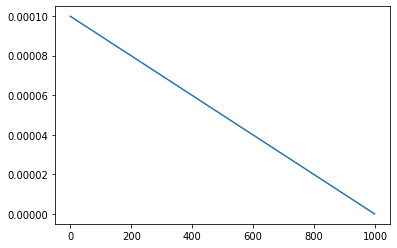

In [11]:
import matplotlib.pyplot as plt
x = list(range(0,1000))
y = lr
plt.plot(x,y)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
learning_rate = 1e-4
optimizer = AdamW(model.parameters(),lr=learning_rate)
lambda1 = lambda epoch: epoch // 30

scheduler = LambdaLR(optimizer, lr_lambda, last_epoch)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
  """
  Create a schedule with a learning rate that decreases following the values of the cosine function between the
  initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
  initial lr set in the optimizer. Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
  """
def lr_lambda(current_step):
    # Warmup
    if current_step < num_warmup_steps:
      return float(current_step) / float(max(1, num_warmup_steps))
    # decadence
    progress = float(current_step - num_warmup_steps) / float(
      max(1, num_training_steps - num_warmup_steps)
    )
    return max(
      0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    )

  return LambdaLR(optimizer, lr_lambda, last_epoch)

In [1]:
import random
a = random.randint(3,45)
print(a)

33
